<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/DenseNet_Train_Test_2class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## แก้เป็น sigmoid เลย
1) K-fold อันเดิมที่เปลี่ยนแค่ BS ยังไม่มีการเปลี่ยน loss, optimizer

2) All Abnormal ครบหมดแล้ว เช็คแล้ว เป็นการ Train-Test มี binary , categorical, RMSprop, Adam  

3) Sampling Abnormal ครบหมดแล้ว เช็คแล้ว เป็นการ Train-Test มี binary , categorical, RMSprop, Adam



#### import

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#### Load data // KKU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Load data // Gmail

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### Data 2 class + Sampling data
* ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

* 50%ของแถวทั้งหมด --> 
df = df.sample(frac=0.50)

* สุ่มแถวเดิมซ้ำกันได้ -->
df = df.sample(n=3,replace=True)

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [ ]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal"  })

In [ ]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Abnormal"  })

In [ ]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Abnormal"  })

In [ ]:
data_train3 = pd.concat([tnormal[:-1], ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType
147,ca1.jpg,Abnormal
148,ca8.jpg,Abnormal
149,ca26.jpg,Abnormal


In [ ]:
data_train3.shape

(450, 2)

##### Sampling data

In [ ]:
tabnormal= pd.concat([ttuberculosis, tlungcancer])
tabnormal = tabnormal.sample(n=150, random_state=40)
data_train3 = pd.concat([tnormal[:-1], tabnormal])

In [ ]:
data_train3.shape

(300, 2)

In [ ]:
data_train3.to_excel("data_2class_all.xlsx")

# Pretrained Sampling Abnormal  

###  8 
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam
- ModelCheckpoint():
ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling
นามสกุลก็จะเป็น .5df เฉพาะ Packages Keras เท่านั้น
- ReduceLROnPlateau(): ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
    - monitor= ’val_loss’: ใช้ Criteria อะไรในการลด Learning Rate
    - patience= 5: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
    - verbose= 2: รูปแบบการแสดงผลหากเกิด Effect
    - factor= 0.5: หากไม่สามารถลด loss ได้ใน 5 epoch ทำการลด learning rate 50%

#### 8  soft pre bi
--> 0.88

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:05<00:00, 56.53it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.5300
Epoch 1: val_accuracy improved from -inf to 0.53947, saving model to model8_soft_pre_bi.h5
28/28 [==============================] - 49s 839ms/step - loss: 0.7751 - accuracy: 0.5300 - val_loss: 0.7253 - val_accuracy: 0.5395 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.5714
Epoch 2: val_accuracy improved from 0.53947 to 0.57895, saving model to model8_soft_pre_bi.h5
28/28 [==============================] - 9s 310ms/step - loss: 0.6888 - accuracy: 0.5714 - val_loss: 0.6858 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6221
Epoch 3: val_accuracy improved from 0.57895 to 0.63158, saving model to model8_soft_pre_bi.h5
28/28 [==============================] - 9s 340ms/step - loss: 0.6521 - accuracy: 0.6221 - val_loss: 0.6562 - val_accuracy: 0.6316 - lr: 1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

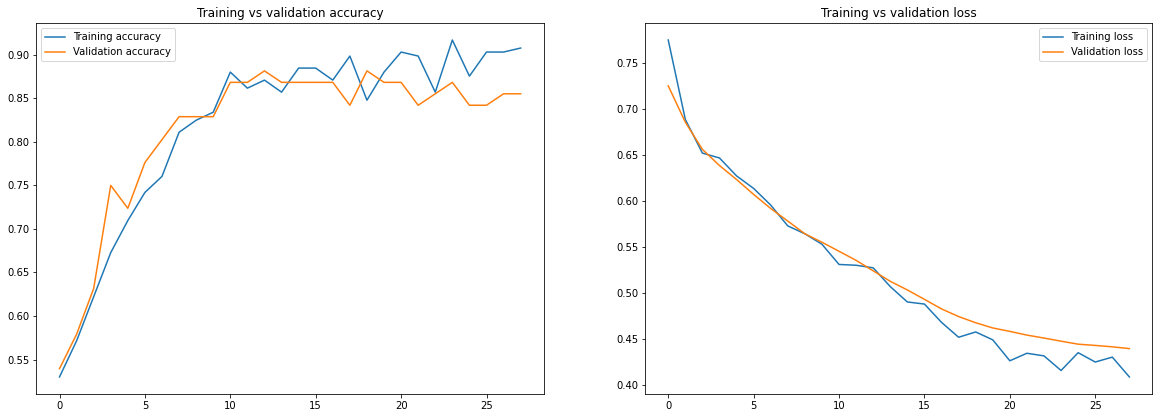

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[29  7]
 [ 4 36]]
Normalized confusion matrix
[[0.81 0.19]
 [0.1  0.9 ]]


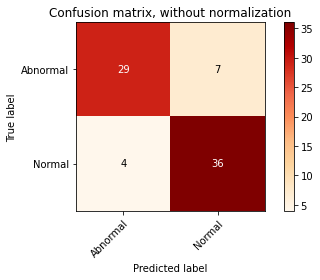

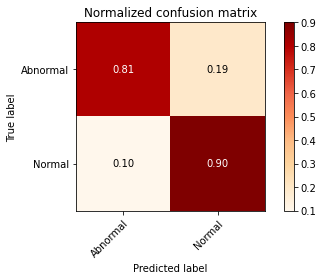

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam
--> 0.89

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:04<00:00, 73.65it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.5530
Epoch 1: val_accuracy improved from -inf to 0.55263, saving model to model8_soft_pre_bi_adam.h5
28/28 [==============================] - 24s 403ms/step - loss: 0.7402 - accuracy: 0.5530 - val_loss: 0.7055 - val_accuracy: 0.5526 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.6359
Epoch 2: val_accuracy improved from 0.55263 to 0.56579, saving model to model8_soft_pre_bi_adam.h5
28/28 [==============================] - 7s 234ms/step - loss: 0.6768 - accuracy: 0.6359 - val_loss: 0.6772 - val_accuracy: 0.5658 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6774
Epoch 3: val_accuracy improved from 0.56579 to 0.61842, saving model to model8_soft_pre_bi_adam.h5
28/28 [==============================] - 7s 236ms/step - loss: 0.6563 - accuracy: 0.6774 - val_loss: 0.6606 - val_accuracy: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

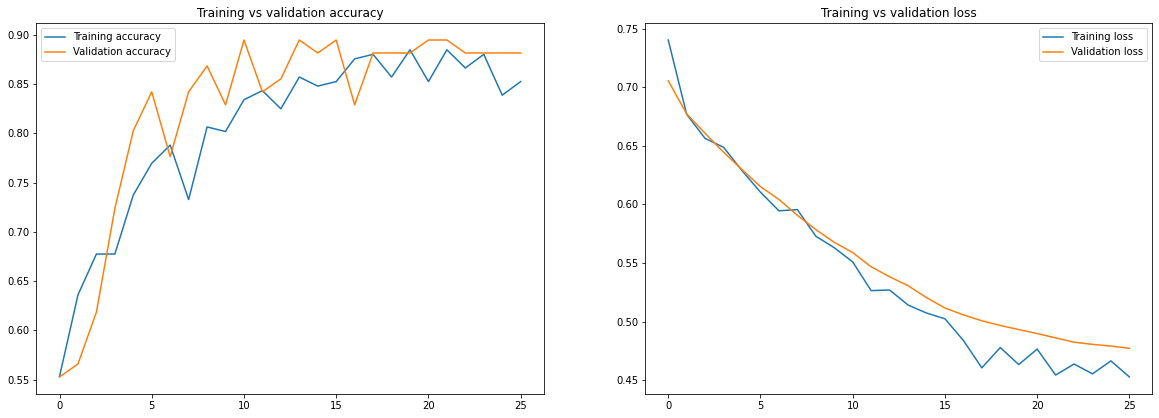

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[30  6]
 [ 3 37]]
Normalized confusion matrix
[[0.83 0.17]
 [0.07 0.93]]


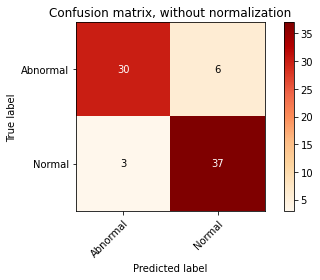

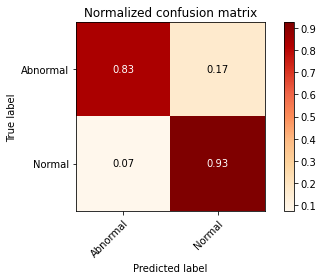

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate 
--> 0.89

In [ ]:
BS = 8                                                             ##
filepath = "model8_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 75.57it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.5438
Epoch 1: val_accuracy improved from -inf to 0.47368, saving model to model8_soft_pre_cate.h5
28/28 [==============================] - 24s 382ms/step - loss: 0.9159 - accuracy: 0.5438 - val_loss: 0.7448 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.5300
Epoch 2: val_accuracy improved from 0.47368 to 0.51316, saving model to model8_soft_pre_cate.h5
28/28 [==============================] - 7s 252ms/step - loss: 0.7038 - accuracy: 0.5300 - val_loss: 0.6994 - val_accuracy: 0.5132 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.6544
Epoch 3: val_accuracy improved from 0.51316 to 0.57895, saving model to model8_soft_pre_cate.h5
28/28 [==============================] - 7s 260ms/step - loss: 0.6664 - accuracy: 0.6544 - val_loss: 0.6668 - val_accuracy: 0.5789 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

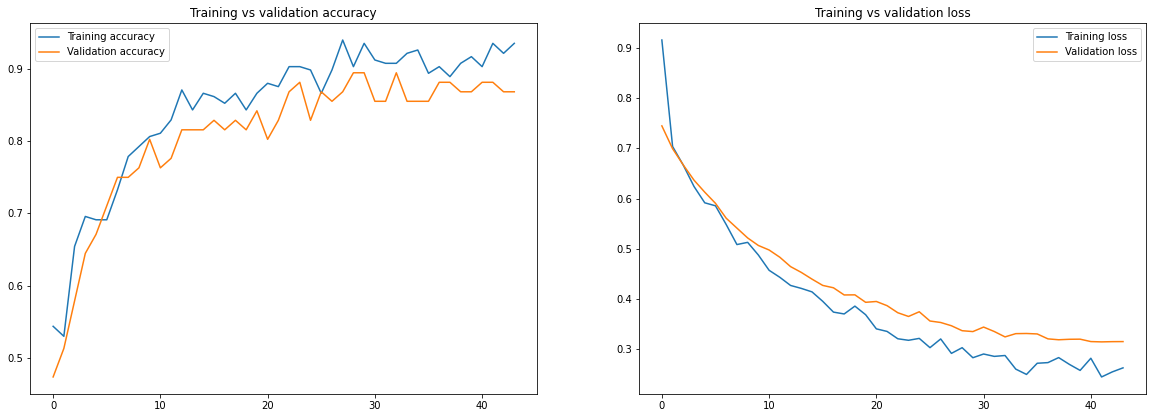

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate                            ##
pred_Dense = pred_H8_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[28  8]
 [ 2 38]]
Normalized confusion matrix
[[0.78 0.22]
 [0.05 0.95]]


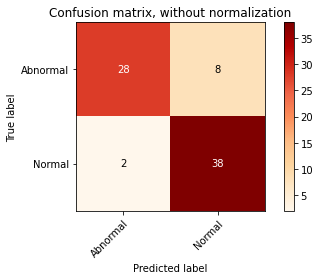

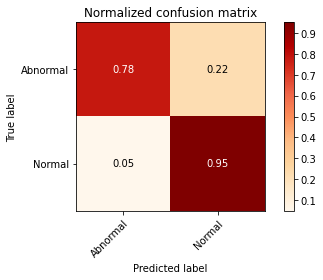

In [ ]:
y_pred = pred_H8_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate adam
--> 0.87

In [ ]:
BS = 8                                                       ##
filepath = "model8_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 78.40it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.5438
Epoch 1: val_accuracy improved from -inf to 0.67105, saving model to model8_soft_pre_cate_adam.h5
28/28 [==============================] - 24s 389ms/step - loss: 0.7337 - accuracy: 0.5438 - val_loss: 0.6247 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.6452
Epoch 2: val_accuracy improved from 0.67105 to 0.71053, saving model to model8_soft_pre_cate_adam.h5
28/28 [==============================] - 7s 234ms/step - loss: 0.6442 - accuracy: 0.6452 - val_loss: 0.5983 - val_accuracy: 0.7105 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.6024 - accuracy: 0.6912
Epoch 3: val_accuracy improved from 0.71053 to 0.72368, saving model to model8_soft_pre_cate_adam.h5
28/28 [==============================] - 7s 238ms/step - loss: 0.6024 - accuracy: 0.6912 - val_loss: 0.5735 - val_accu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

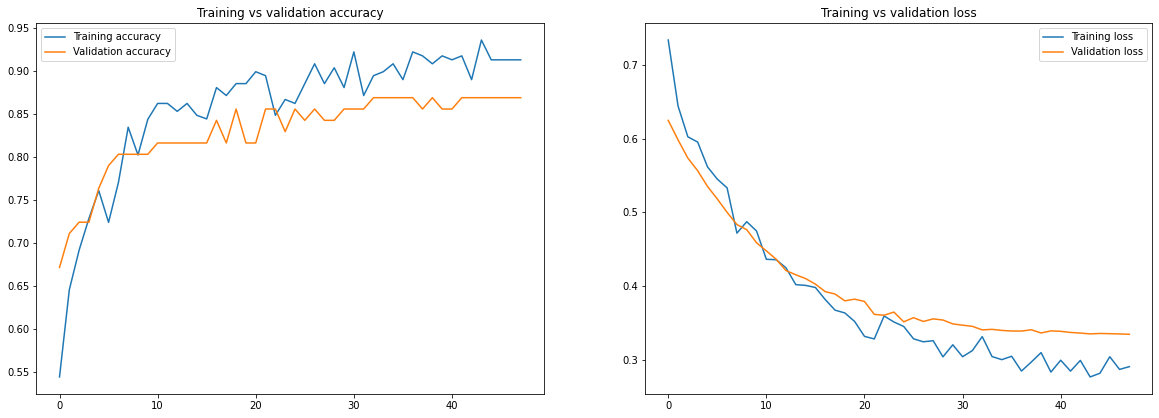

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate_adam                            ##
pred_Dense = pred_H8_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[28  8]
 [ 2 38]]
Normalized confusion matrix
[[0.78 0.22]
 [0.05 0.95]]


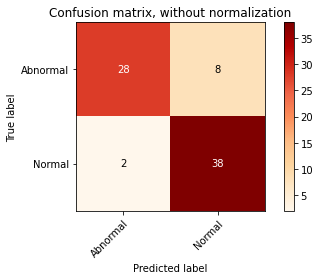

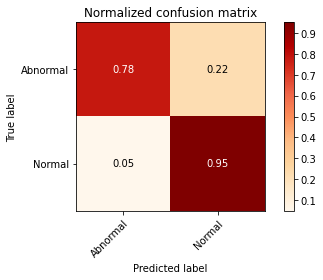

In [ ]:
y_pred = pred_H8_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 16  


#### 16  soft pre bi
--> 0.84

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:04<00:00, 60.26it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.6603
Epoch 1: val_accuracy improved from -inf to 0.55263, saving model to model16_soft_pre_bi.h5
14/14 [==============================] - 39s 1s/step - loss: 0.6589 - accuracy: 0.6603 - val_loss: 0.6772 - val_accuracy: 0.5526 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.7177
Epoch 2: val_accuracy improved from 0.55263 to 0.65789, saving model to model16_soft_pre_bi.h5
14/14 [==============================] - 8s 583ms/step - loss: 0.6474 - accuracy: 0.7177 - val_loss: 0.6636 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.7416
Epoch 3: val_accuracy did not improve from 0.65789
14/14 [==============================] - 6s 413ms/step - loss: 0.6261 - accuracy: 0.7416 - val_loss: 0.6580 - val_accuracy: 0.6184 - lr: 1.0000e-04
Epoch 4/100
14/14 [================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

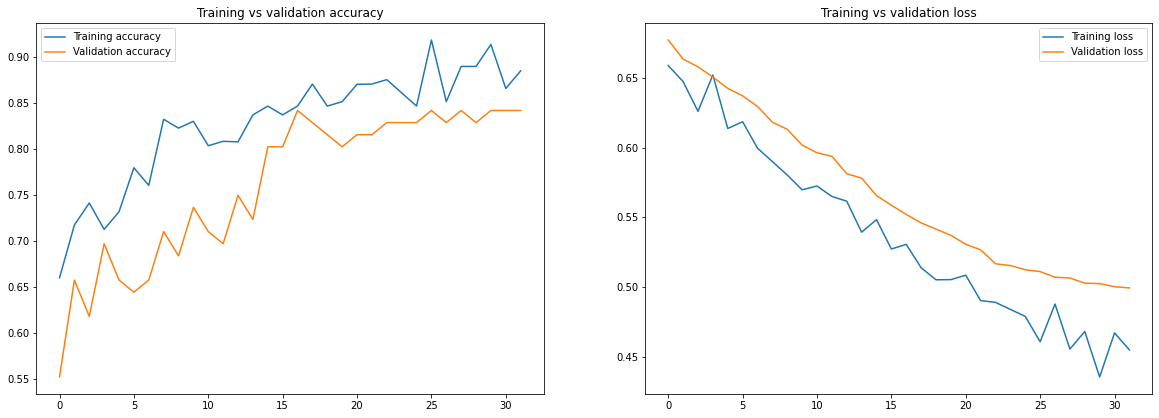

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25 11]
 [ 1 39]]
Normalized confusion matrix
[[0.69 0.31]
 [0.03 0.97]]


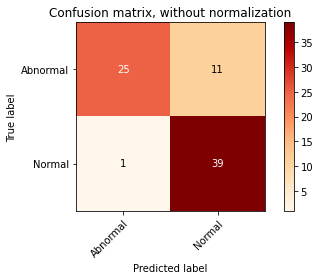

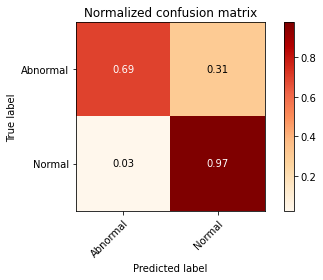

In [ ]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre bi adam
--> 0.83

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 83.06it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5072
Epoch 1: val_accuracy improved from -inf to 0.55263, saving model to model16_soft_pre_bi_adam.h5
14/14 [==============================] - 21s 689ms/step - loss: 0.6909 - accuracy: 0.5072 - val_loss: 0.6805 - val_accuracy: 0.5526 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6172
Epoch 2: val_accuracy improved from 0.55263 to 0.59211, saving model to model16_soft_pre_bi_adam.h5
14/14 [==============================] - 6s 420ms/step - loss: 0.6785 - accuracy: 0.6172 - val_loss: 0.6692 - val_accuracy: 0.5921 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.6364
Epoch 3: val_accuracy improved from 0.59211 to 0.61842, saving model to model16_soft_pre_bi_adam.h5
14/14 [==============================] - 6s 426ms/step - loss: 0.6734 - accuracy: 0.6364 - val_loss: 0.6598 - val_accurac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

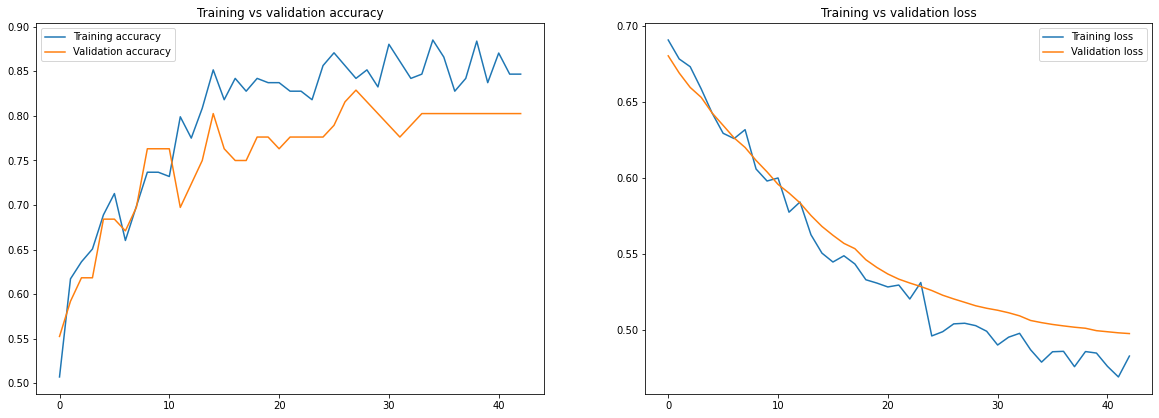

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24 12]
 [ 3 37]]
Normalized confusion matrix
[[0.67 0.33]
 [0.07 0.93]]


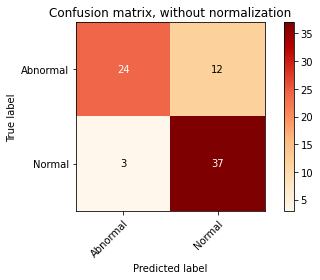

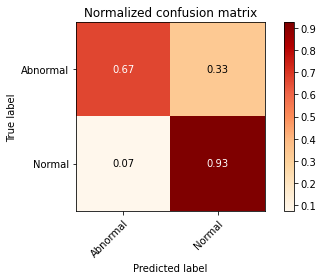

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate 
--> 0.88

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 82.33it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.5359
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model16_soft_pre_cate.h5
14/14 [==============================] - 23s 706ms/step - loss: 0.7066 - accuracy: 0.5359 - val_loss: 0.7061 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.6172
Epoch 2: val_accuracy improved from 0.50000 to 0.55263, saving model to model16_soft_pre_cate.h5
14/14 [==============================] - 6s 441ms/step - loss: 0.6616 - accuracy: 0.6172 - val_loss: 0.6907 - val_accuracy: 0.5526 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.6603
Epoch 3: val_accuracy improved from 0.55263 to 0.57895, saving model to model16_soft_pre_cate.h5
14/14 [==============================] - 7s 475ms/step - loss: 0.6319 - accuracy: 0.6603 - val_loss: 0.6685 - val_accuracy: 0.5789

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

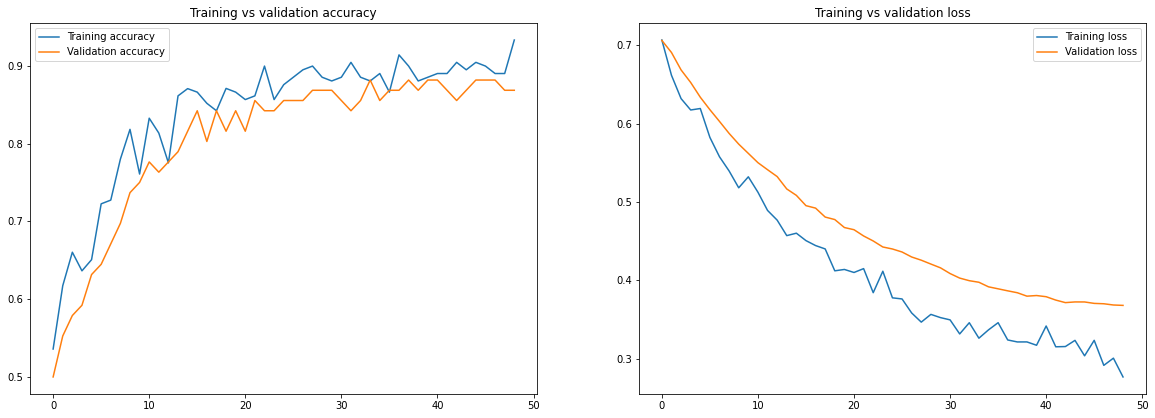

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate                            ##
pred_Dense = pred_H16_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[29  7]
 [ 3 37]]
Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


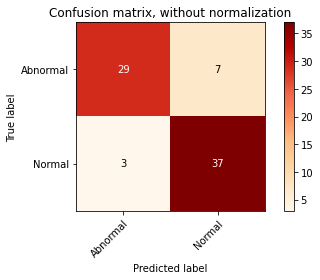

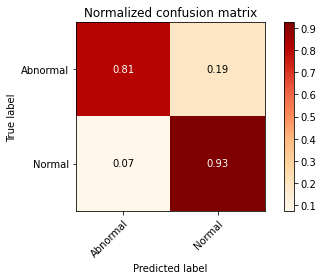

In [ ]:
y_pred = pred_H16_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate adam
--> 0.89

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 80.83it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)     

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.5981
Epoch 1: val_accuracy improved from -inf to 0.71053, saving model to model16_soft_pre_cate_adam.h5
14/14 [==============================] - 23s 706ms/step - loss: 0.6584 - accuracy: 0.5981 - val_loss: 0.6212 - val_accuracy: 0.7105 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.6794
Epoch 2: val_accuracy did not improve from 0.71053
14/14 [==============================] - 4s 301ms/step - loss: 0.6144 - accuracy: 0.6794 - val_loss: 0.6111 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.7129
Epoch 3: val_accuracy improved from 0.71053 to 0.75000, saving model to model16_soft_pre_cate_adam.h5
14/14 [==============================] - 6s 428ms/step - loss: 0.6063 - accuracy: 0.7129 - val_loss: 0.5882 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/100
14/14 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

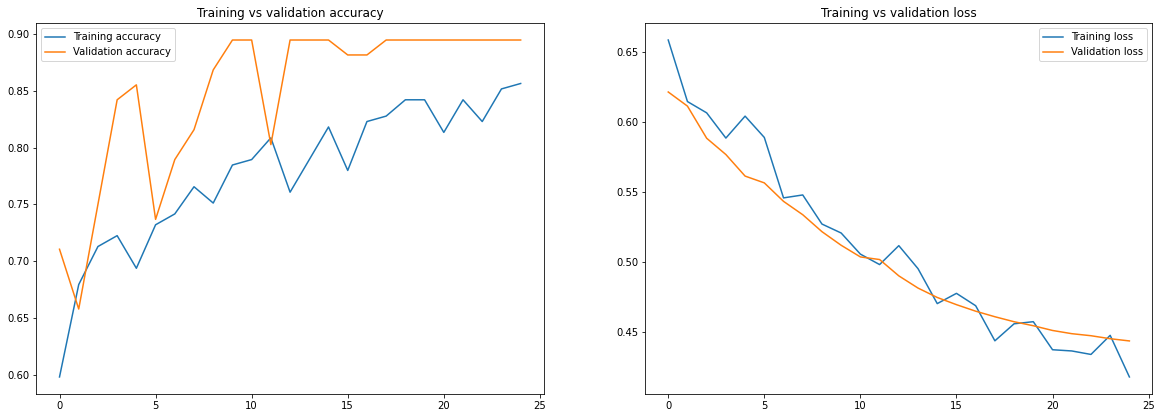

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate_adam                            ##
pred_Dense = pred_H16_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[30  6]
 [ 2 38]]
Normalized confusion matrix
[[0.83 0.17]
 [0.05 0.95]]


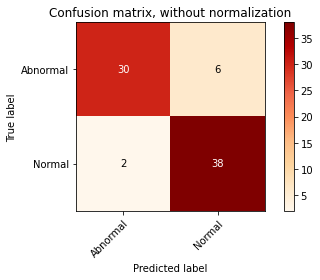

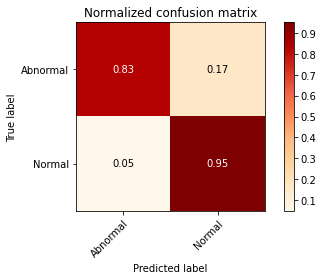

In [ ]:
y_pred = pred_H16_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 32

#### 32  soft pre bi
--> 0.84

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 82.33it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H32_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H32_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.7811 - accuracy: 0.4456
Epoch 1: val_accuracy improved from -inf to 0.43421, saving model to model32_soft_pre_bi.h5
7/7 [==============================] - 22s 2s/step - loss: 0.7811 - accuracy: 0.4456 - val_loss: 0.7742 - val_accuracy: 0.4342 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.4922
Epoch 2: val_accuracy did not improve from 0.43421
7/7 [==============================] - 4s 573ms/step - loss: 0.7489 - accuracy: 0.4922 - val_loss: 0.7598 - val_accuracy: 0.4342 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.7417 - accuracy: 0.4819
Epoch 3: val_accuracy did not improve from 0.43421
7/7 [==============================] - 4s 569ms/step - loss: 0.7417 - accuracy: 0.4819 - val_loss: 0.7480 - val_accuracy: 0.4342 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.487

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

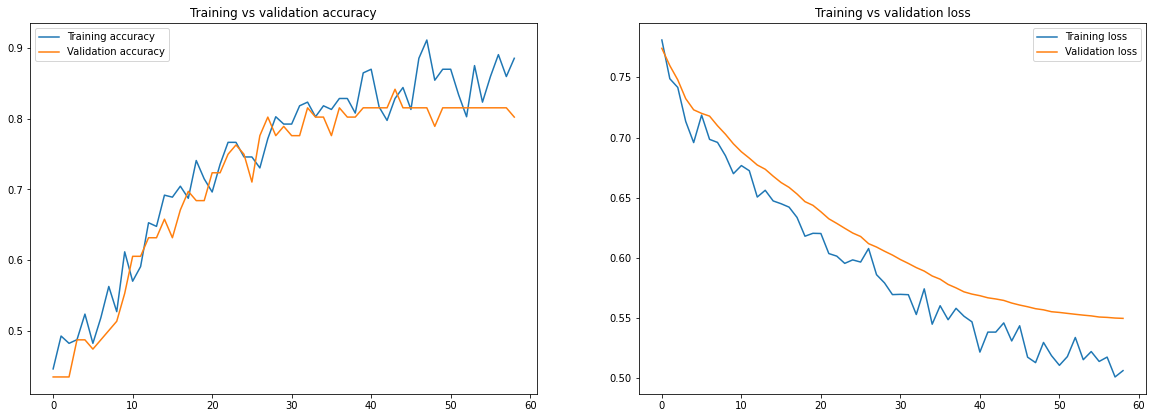

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi                            ##
pred_Dense = pred_H32_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24 12]
 [ 3 37]]
Normalized confusion matrix
[[0.67 0.33]
 [0.07 0.93]]


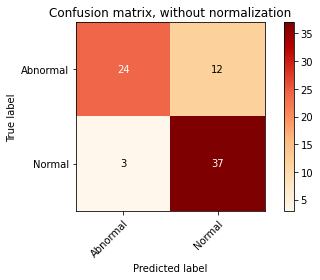

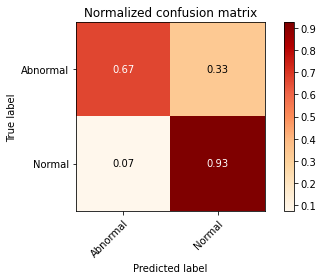

In [ ]:
y_pred = pred_H32_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi adam
--> 0.84

In [ ]:
BS = 32                                                      ##
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 81.82it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.5285
Epoch 1: val_accuracy improved from -inf to 0.57895, saving model to model32_soft_pre_bi_adam.h5
7/7 [==============================] - 22s 1s/step - loss: 0.7425 - accuracy: 0.5285 - val_loss: 0.6821 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.5492
Epoch 2: val_accuracy improved from 0.57895 to 0.67105, saving model to model32_soft_pre_bi_adam.h5
7/7 [==============================] - 6s 844ms/step - loss: 0.6981 - accuracy: 0.5492 - val_loss: 0.6567 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.5907
Epoch 3: val_accuracy did not improve from 0.67105
7/7 [==============================] - 4s 556ms/step - loss: 0.6724 - accuracy: 0.5907 - val_loss: 0.6388 - val_accuracy: 0.6579 - lr: 1.0000e-04
Epoch 4/100
7/7 [====================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

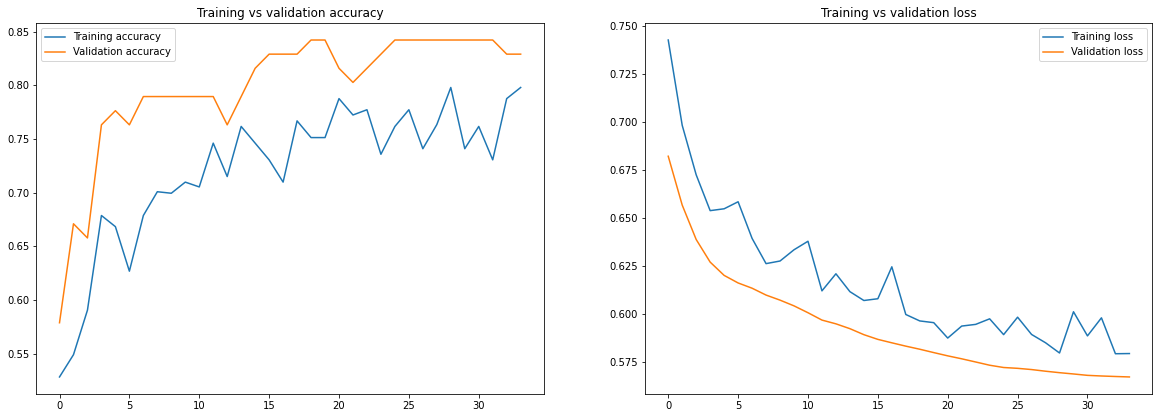

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi_adam                            ##
pred_Dense = pred_H32_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25 11]
 [ 2 38]]
Normalized confusion matrix
[[0.69 0.31]
 [0.05 0.95]]


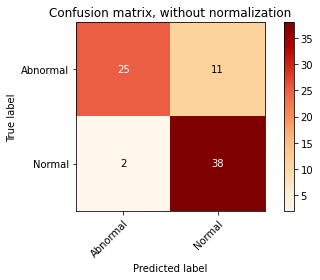

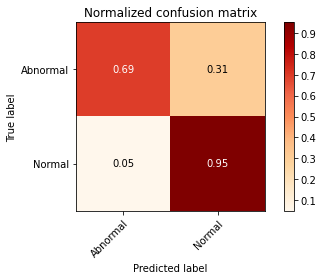

In [ ]:
y_pred = pred_H32_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate 
--> 0.85

In [ ]:
BS = 32                                                             ##
filepath = "model32_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 81.10it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.4974
Epoch 1: val_accuracy improved from -inf to 0.51316, saving model to model32_soft_pre_cate.h5
7/7 [==============================] - 23s 1s/step - loss: 0.8085 - accuracy: 0.4974 - val_loss: 0.7785 - val_accuracy: 0.5132 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.8159 - accuracy: 0.4404
Epoch 2: val_accuracy did not improve from 0.51316
7/7 [==============================] - 4s 564ms/step - loss: 0.8159 - accuracy: 0.4404 - val_loss: 0.7471 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.4093
Epoch 3: val_accuracy did not improve from 0.51316
7/7 [==============================] - 4s 568ms/step - loss: 0.7865 - accuracy: 0.4093 - val_loss: 0.7241 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

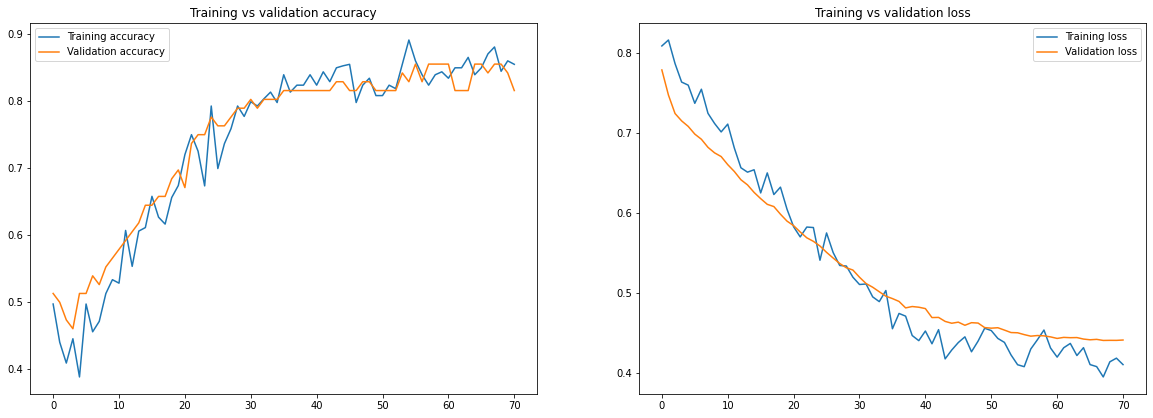

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate                            ##
pred_Dense = pred_H32_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24 12]
 [ 2 38]]
Normalized confusion matrix
[[0.67 0.33]
 [0.05 0.95]]


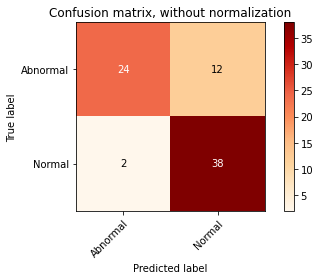

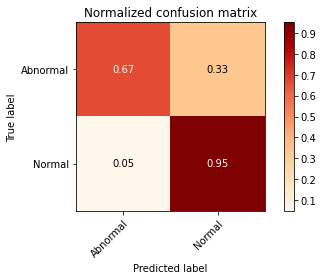

In [ ]:
y_pred = pred_H32_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate adam
--> 0.83

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 80.57it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense,  batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.6562
Epoch 1: val_accuracy improved from -inf to 0.67105, saving model to model32_soft_pre_cate_adam.h5
7/7 [==============================] - 22s 1s/step - loss: 0.6387 - accuracy: 0.6562 - val_loss: 0.6260 - val_accuracy: 0.6711 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.6736
Epoch 2: val_accuracy improved from 0.67105 to 0.68421, saving model to model32_soft_pre_cate_adam.h5
7/7 [==============================] - 6s 917ms/step - loss: 0.6179 - accuracy: 0.6736 - val_loss: 0.6263 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.6839
Epoch 3: val_accuracy did not improve from 0.68421
7/7 [==============================] - 4s 574ms/step - loss: 0.6047 - accuracy: 0.6839 - val_loss: 0.6199 - val_accuracy: 0.6842 - lr: 1.0000e-04
Epoch 4/100
7/7 [================

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

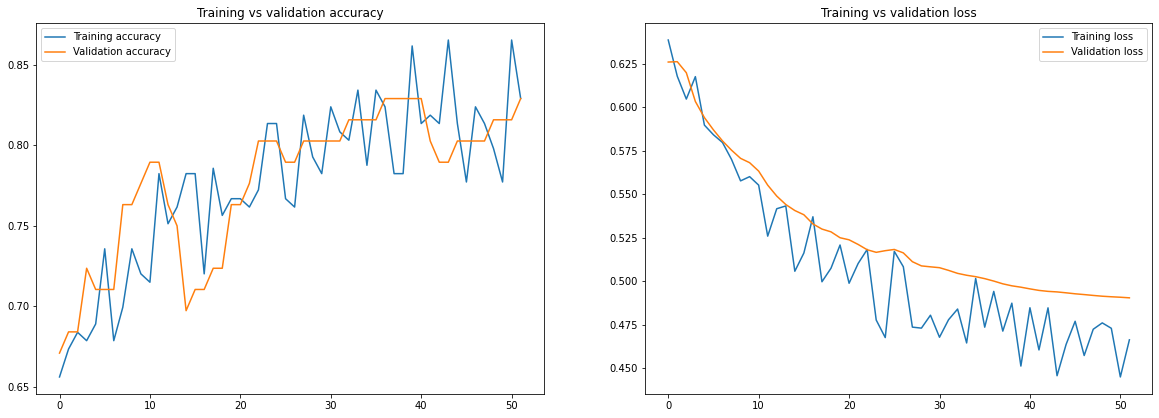

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate_adam                            ##
pred_Dense = pred_H32_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[29  7]
 [ 6 34]]
Normalized confusion matrix
[[0.81 0.19]
 [0.15 0.85]]


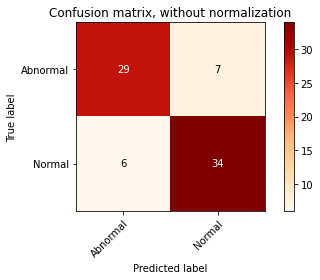

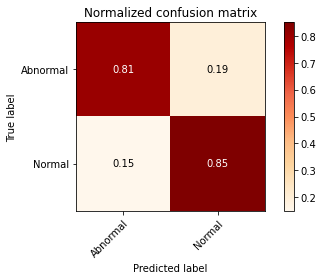

In [ ]:
y_pred = pred_H32_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1

#### 1  soft pre bi
--> 0.89

In [ ]:
BS = 1                                                      ##
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 80.09it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H1_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H1_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.4444
Epoch 1: val_accuracy improved from -inf to 0.56579, saving model to model1_soft_pre_bi.h5
225/225 [==============================] - 33s 93ms/step - loss: 0.7579 - accuracy: 0.4444 - val_loss: 0.7029 - val_accuracy: 0.5658 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.6267
Epoch 2: val_accuracy improved from 0.56579 to 0.75000, saving model to model1_soft_pre_bi.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.6700 - accuracy: 0.6267 - val_loss: 0.6479 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.7289
Epoch 3: val_accuracy improved from 0.75000 to 0.78947, saving model to model1_soft_pre_bi.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.6141 - accuracy: 0.7289 - val_loss: 0.6039 - val_accuracy: 0.78

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

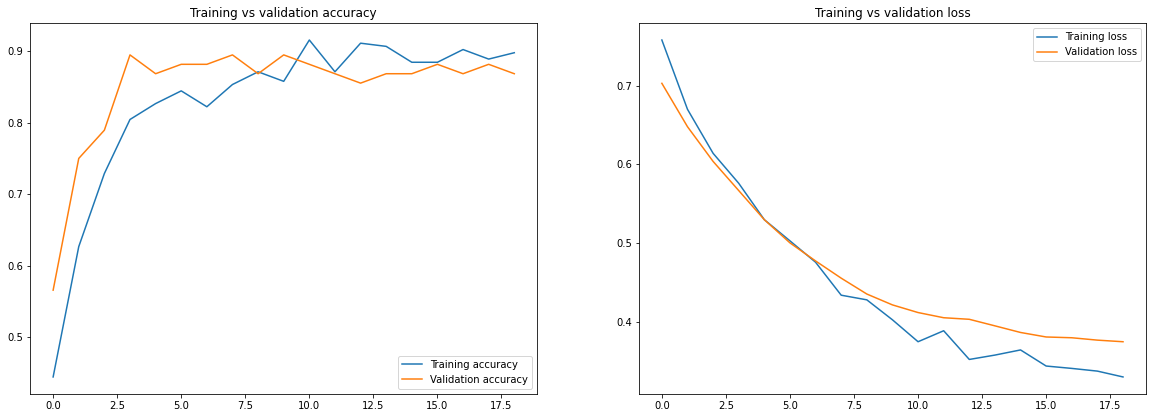

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi                            ##
pred_Dense = pred_H1_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[28  8]
 [ 2 38]]
Normalized confusion matrix
[[0.78 0.22]
 [0.05 0.95]]


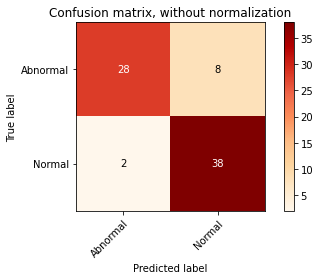

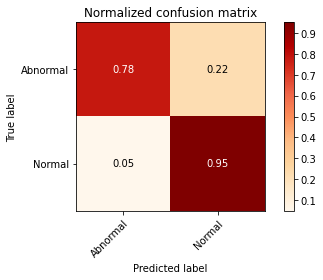

In [ ]:
y_pred = pred_H1_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam
--> 0.89

In [ ]:
BS = 1                                                            ##
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 76.43it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.6622
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to model1_soft_pre_bi_adam.h5
225/225 [==============================] - 34s 96ms/step - loss: 0.6453 - accuracy: 0.6622 - val_loss: 0.6163 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7822
Epoch 2: val_accuracy improved from 0.75000 to 0.81579, saving model to model1_soft_pre_bi_adam.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.5906 - accuracy: 0.7822 - val_loss: 0.5715 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.8178
Epoch 3: val_accuracy did not improve from 0.81579
225/225 [==============================] - 16s 69ms/step - loss: 0.5540 - accuracy: 0.8178 - val_loss: 0.5432 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 4/100
2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

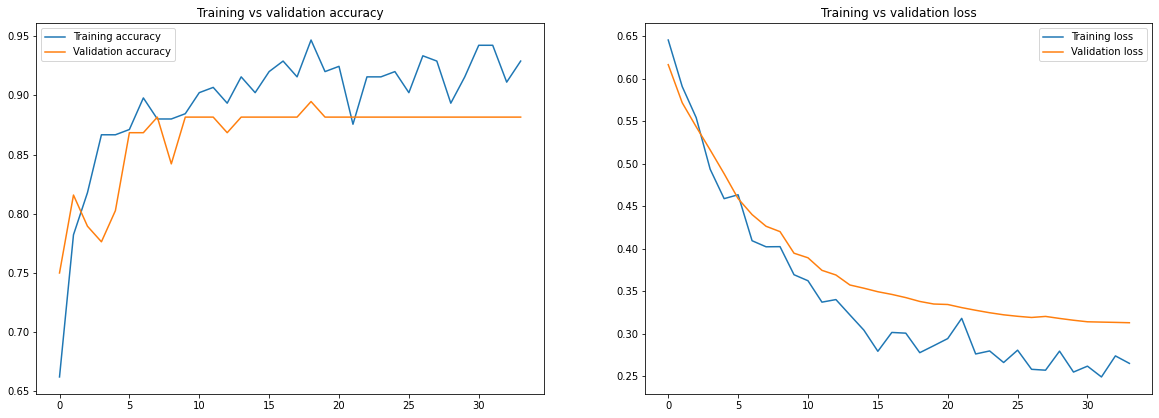

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi_adam                            ##
pred_Dense = pred_H1_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[29  7]
 [ 2 38]]
Normalized confusion matrix
[[0.81 0.19]
 [0.05 0.95]]


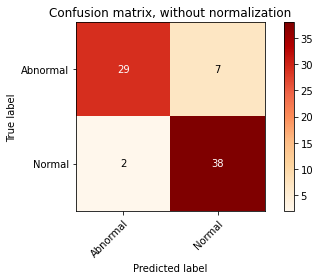

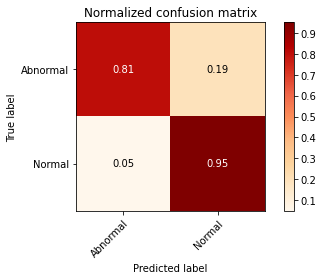

In [ ]:
y_pred = pred_H1_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate 
--> 0.87

In [ ]:
BS = 1                                                             ##
filepath = "mode1_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:03<00:00, 78.44it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5600
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to mode1_soft_pre_cate.h5
225/225 [==============================] - 36s 104ms/step - loss: 0.6926 - accuracy: 0.5600 - val_loss: 0.7416 - val_accuracy: 0.5263 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.6711
Epoch 2: val_accuracy improved from 0.52632 to 0.72368, saving model to mode1_soft_pre_cate.h5
225/225 [==============================] - 18s 78ms/step - loss: 0.5985 - accuracy: 0.6711 - val_loss: 0.5791 - val_accuracy: 0.7237 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.5207 - accuracy: 0.7644
Epoch 3: val_accuracy improved from 0.72368 to 0.75000, saving model to mode1_soft_pre_cate.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.5207 - accuracy: 0.7644 - val_loss: 0.5132 - val_accuracy: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

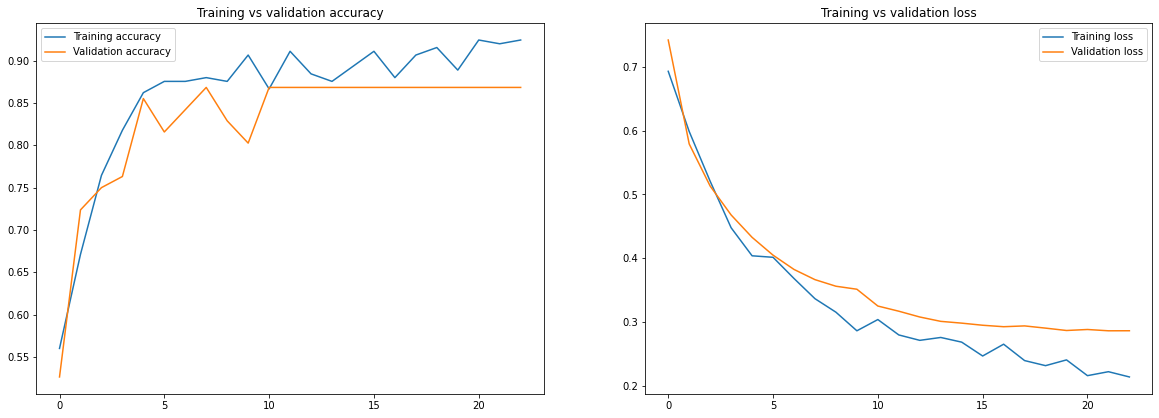

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate                            ##
pred_Dense = pred_H1_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[29  7]
 [ 3 37]]
Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


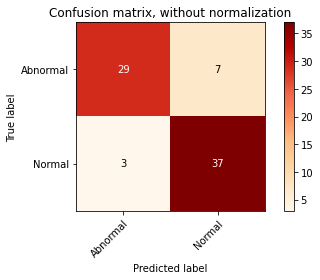

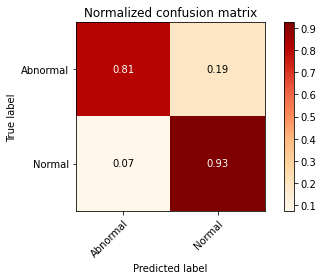

In [ ]:
y_pred = pred_H1_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate adam
--> 0.92

In [ ]:
BS = 1                                                       ##
filepath = "model1_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 301/301 [00:04<00:00, 75.06it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.4178
Epoch 1: val_accuracy improved from -inf to 0.53947, saving model to model1_soft_pre_cate_adam.h5
225/225 [==============================] - 34s 96ms/step - loss: 0.8134 - accuracy: 0.4178 - val_loss: 0.7242 - val_accuracy: 0.5395 - lr: 1.0000e-04
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.5733
Epoch 2: val_accuracy improved from 0.53947 to 0.61842, saving model to model1_soft_pre_cate_adam.h5
225/225 [==============================] - 18s 78ms/step - loss: 0.6709 - accuracy: 0.5733 - val_loss: 0.6219 - val_accuracy: 0.6184 - lr: 1.0000e-04
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.7511
Epoch 3: val_accuracy improved from 0.61842 to 0.72368, saving model to model1_soft_pre_cate_adam.h5
225/225 [==============================] - 17s 77ms/step - loss: 0.5660 - accuracy: 0.7511 - val_loss: 0.5409

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

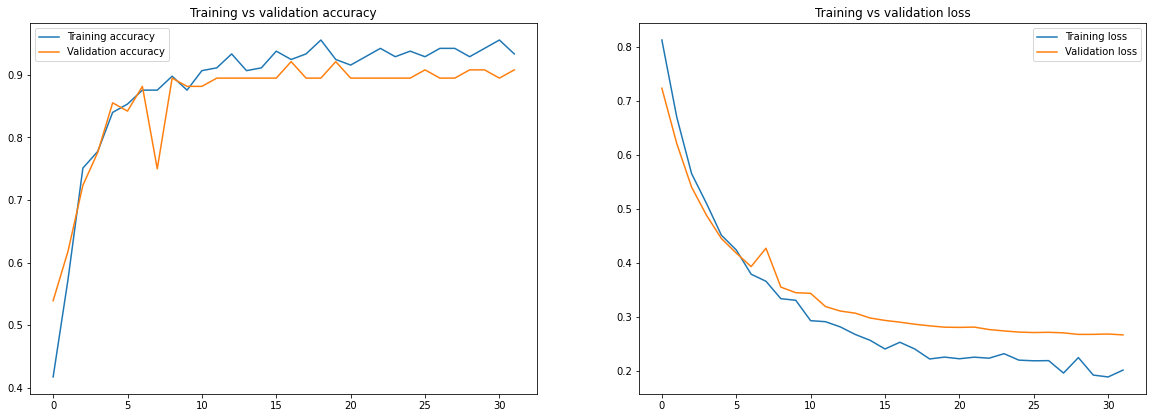

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate_adam                            ##
pred_Dense = pred_H1_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[31  5]
 [ 2 38]]
Normalized confusion matrix
[[0.86 0.14]
 [0.05 0.95]]


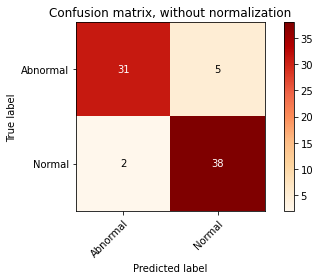

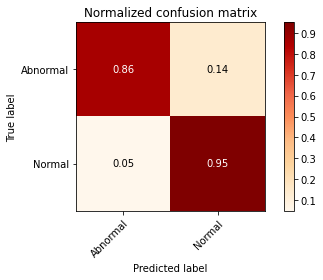

In [ ]:
y_pred = pred_H1_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# 0-400 Sampling Abnormal  

#### 8  soft fine bi
--> 0.947

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_fine_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:06<00:00, 46.61it/s]


In [ ]:
(x_train_Dense, x_test_Dense, y_train_Dense, y_test_Dense ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.8525
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to model8_soft_fine_bi.h5
28/28 [==============================] - 44s 543ms/step - loss: 0.3471 - accuracy: 0.8525 - val_loss: 0.5295 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9078
Epoch 2: val_accuracy did not improve from 0.72000
28/28 [==============================] - 4s 131ms/step - loss: 0.2136 - accuracy: 0.9078 - val_loss: 0.8275 - val_accuracy: 0.6533 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9447
Epoch 3: val_accuracy did not improve from 0.72000
28/28 [==============================] - 4s 130ms/step - loss: 0.1419 - accuracy: 0.9447 - val_loss: 0.8229 - val_accuracy: 0.7067 - lr: 1.0000e-04
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.1135 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

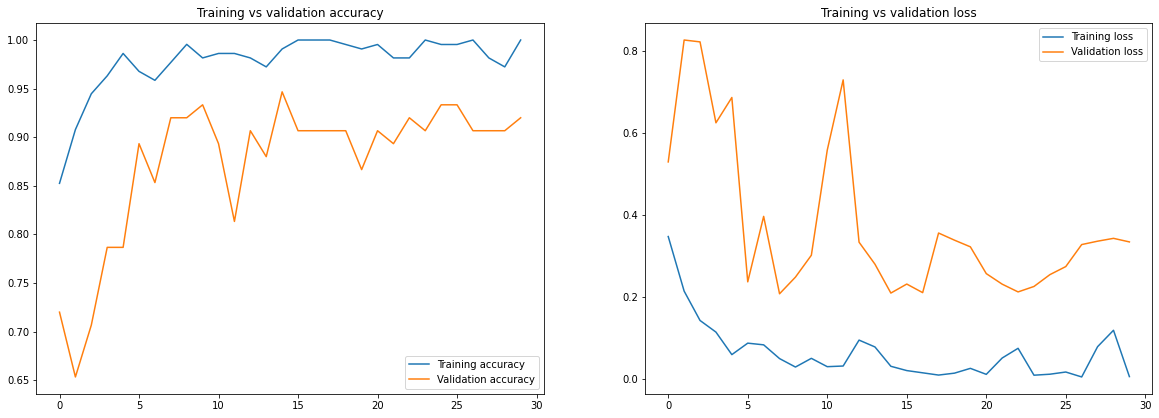

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[35  0]
 [ 6 34]]
Normalized confusion matrix
[[1.   0.  ]
 [0.15 0.85]]


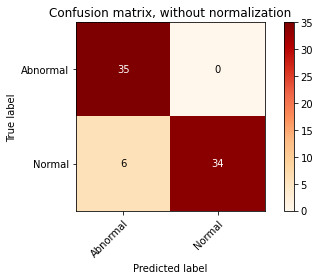

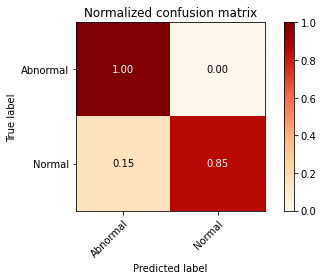

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.90      1.00      0.95        35
      Normal       1.00      0.90      0.95        40

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



Confusion matrix, without normalization
[[35  0]
 [ 4 36]]
Normalized confusion matrix
[[1.  0. ]
 [0.1 0.9]]


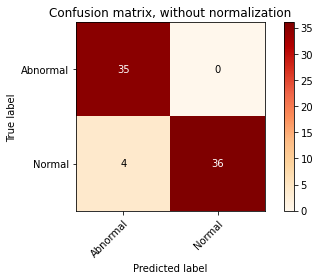

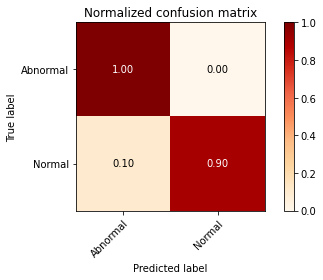

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft fine bi adam
--> 0.947

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_fine_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:02<00:00, 127.81it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8525
Epoch 1: val_accuracy improved from -inf to 0.66667, saving model to model8_soft_fine_bi_adam.h5
28/28 [==============================] - 21s 331ms/step - loss: 0.3852 - accuracy: 0.8525 - val_loss: 0.6340 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9355
Epoch 2: val_accuracy improved from 0.66667 to 0.69333, saving model to model8_soft_fine_bi_adam.h5
28/28 [==============================] - 6s 201ms/step - loss: 0.1843 - accuracy: 0.9355 - val_loss: 0.7720 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9401
Epoch 3: val_accuracy improved from 0.69333 to 0.72000, saving model to model8_soft_fine_bi_adam.h5
28/28 [==============================] - 6s 212ms/step - loss: 0.2119 - accuracy: 0.9401 - val_loss: 0.7236 - val_accurac

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

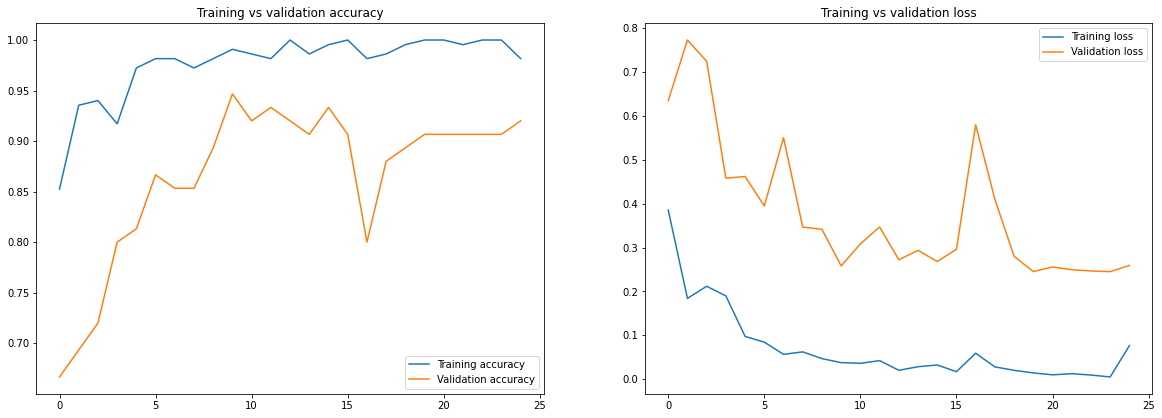

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[34  1]
 [ 5 35]]
Normalized confusion matrix
[[0.97 0.03]
 [0.12 0.88]]


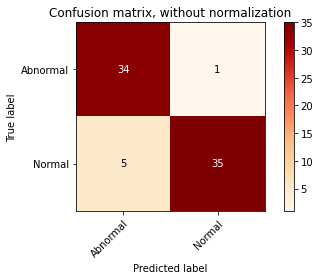

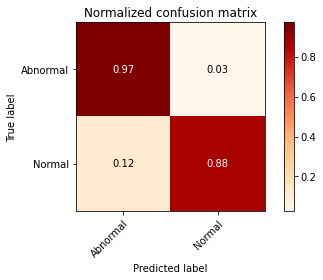

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.92      0.97      0.94        35
      Normal       0.97      0.93      0.95        40

    accuracy                           0.95        75
   macro avg       0.95      0.95      0.95        75
weighted avg       0.95      0.95      0.95        75



Confusion matrix, without normalization
[[34  1]
 [ 3 37]]
Normalized confusion matrix
[[0.97 0.03]
 [0.07 0.93]]


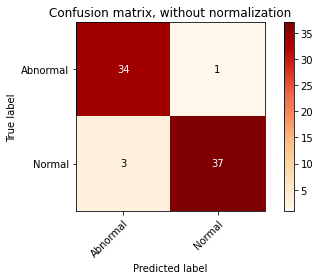

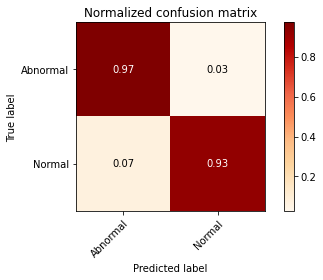

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16  soft fine bi
--> 0.907

In [ ]:
BS = 16                                                       ##
filepath = "model16_fine_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:02<00:00, 127.00it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8995
Epoch 1: val_accuracy improved from -inf to 0.62667, saving model to model16_fine_pre_bi.h5
14/14 [==============================] - 32s 561ms/step - loss: 0.3133 - accuracy: 0.8995 - val_loss: 0.6904 - val_accuracy: 0.6267 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9378
Epoch 2: val_accuracy did not improve from 0.62667
14/14 [==============================] - 4s 259ms/step - loss: 0.1817 - accuracy: 0.9378 - val_loss: 0.8883 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9665
Epoch 3: val_accuracy improved from 0.62667 to 0.65333, saving model to model16_fine_pre_bi.h5
14/14 [==============================] - 5s 344ms/step - loss: 0.1114 - accuracy: 0.9665 - val_loss: 0.8376 - val_accuracy: 0.6533 - lr: 1.0000e-04
Epoch 4/100
14/14 [=============

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

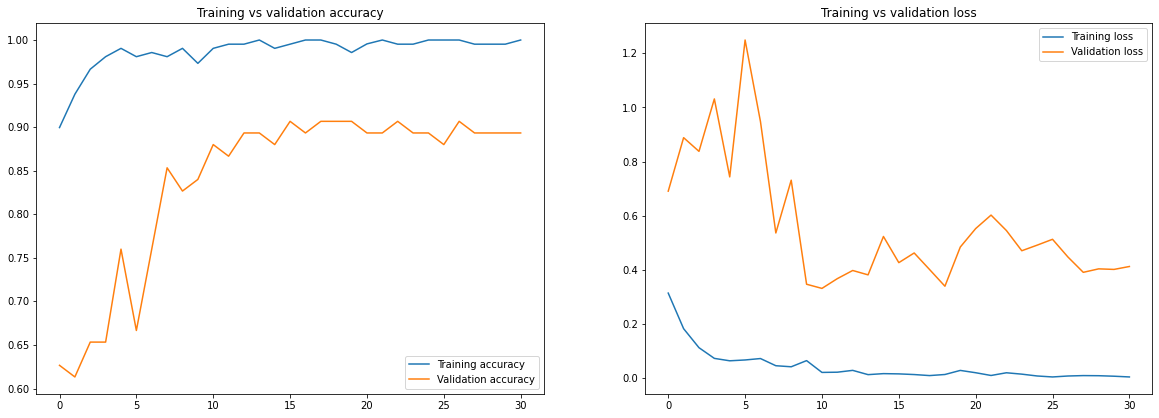

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[32  3]
 [ 5 35]]
Normalized confusion matrix
[[0.91 0.09]
 [0.12 0.88]]


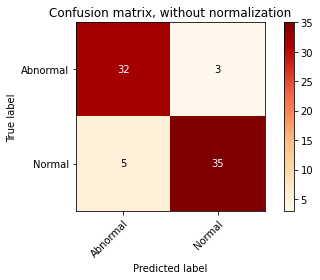

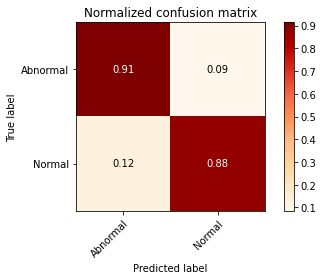

In [ ]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.91      0.89      0.90        35
      Normal       0.90      0.93      0.91        40

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



Confusion matrix, without normalization
[[31  4]
 [ 3 37]]
Normalized confusion matrix
[[0.89 0.11]
 [0.07 0.93]]


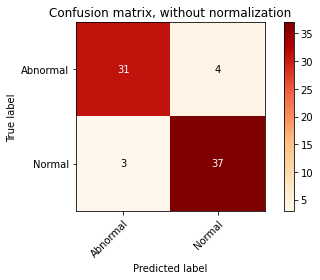

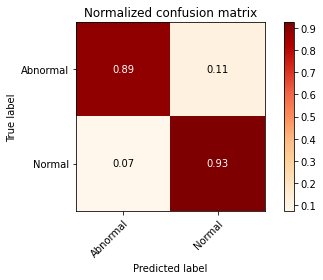

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft fine bi adam
--> 0.907

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_fine_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:02<00:00, 124.94it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.7560
Epoch 1: val_accuracy improved from -inf to 0.82667, saving model to model16_soft_fine_bi_adam.h5
14/14 [==============================] - 21s 592ms/step - loss: 0.4402 - accuracy: 0.7560 - val_loss: 0.4275 - val_accuracy: 0.8267 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9569
Epoch 2: val_accuracy did not improve from 0.82667
14/14 [==============================] - 3s 230ms/step - loss: 0.1753 - accuracy: 0.9569 - val_loss: 0.4611 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9617
Epoch 3: val_accuracy did not improve from 0.82667
14/14 [==============================] - 4s 253ms/step - loss: 0.1173 - accuracy: 0.9617 - val_loss: 0.6247 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

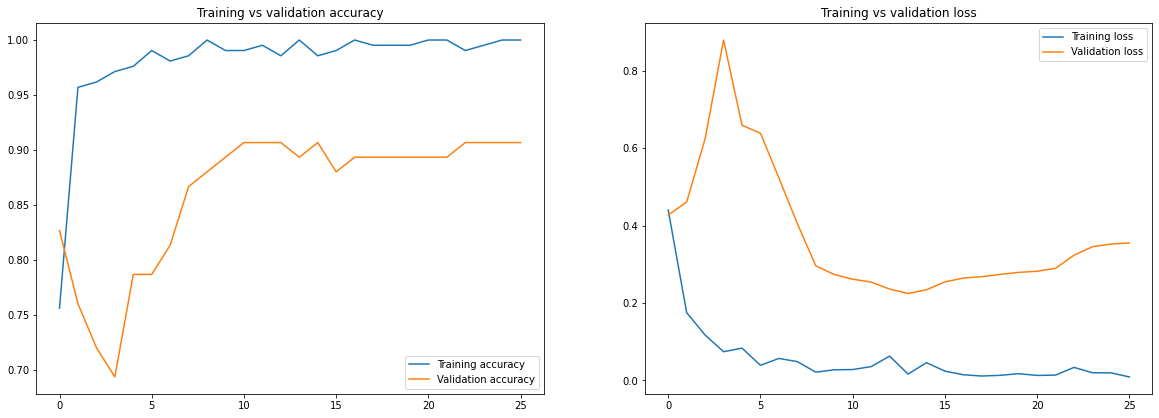

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[34  1]
 [ 6 34]]
Normalized confusion matrix
[[0.97 0.03]
 [0.15 0.85]]


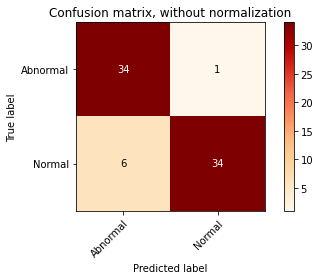

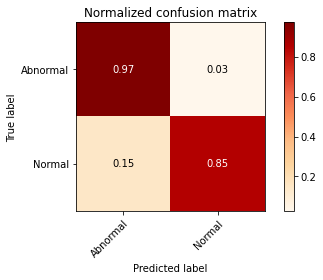

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.94      0.86      0.90        35
      Normal       0.88      0.95      0.92        40

    accuracy                           0.91        75
   macro avg       0.91      0.90      0.91        75
weighted avg       0.91      0.91      0.91        75



Confusion matrix, without normalization
[[30  5]
 [ 2 38]]
Normalized confusion matrix
[[0.86 0.14]
 [0.05 0.95]]


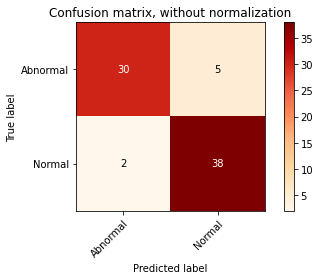

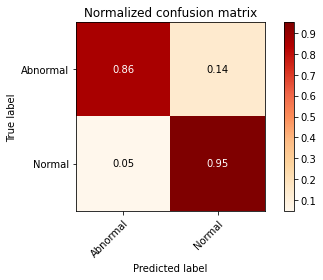

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32  soft fine bi
--> 0.907

In [ ]:
BS = 32                                                       ##
filepath = "model32_fine_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:02<00:00, 126.38it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.3171 - accuracy: 0.8929
Epoch 1: val_accuracy improved from -inf to 0.54667, saving model to model32_fine_pre_bi.h5
7/7 [==============================] - 28s 1s/step - loss: 0.3171 - accuracy: 0.8929 - val_loss: 0.9000 - val_accuracy: 0.5467 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9777
Epoch 2: val_accuracy did not improve from 0.54667
7/7 [==============================] - 4s 500ms/step - loss: 0.1218 - accuracy: 0.9777 - val_loss: 1.2236 - val_accuracy: 0.5467 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9732
Epoch 3: val_accuracy improved from 0.54667 to 0.56000, saving model to model32_fine_pre_bi.h5
7/7 [==============================] - 5s 747ms/step - loss: 0.0871 - accuracy: 0.9732 - val_loss: 1.2059 - val_accuracy: 0.5600 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

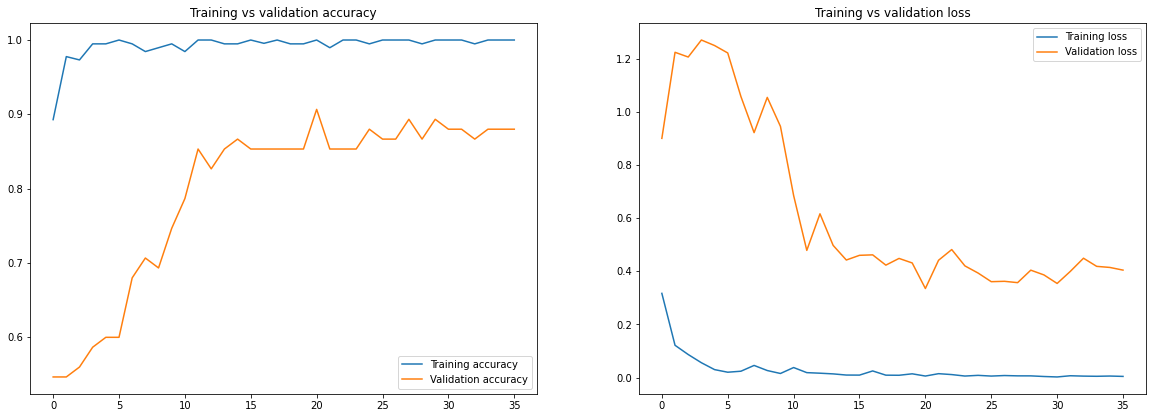

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[30  5]
 [ 4 36]]
Normalized confusion matrix
[[0.86 0.14]
 [0.1  0.9 ]]


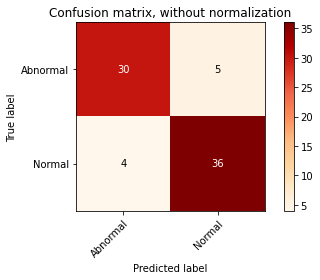

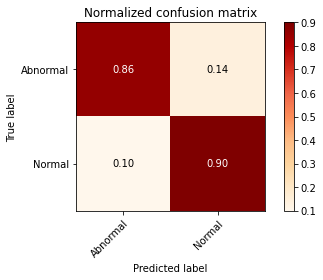

In [ ]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.89      0.91      0.90        35
      Normal       0.92      0.90      0.91        40

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75



Confusion matrix, without normalization
[[32  3]
 [ 4 36]]
Normalized confusion matrix
[[0.91 0.09]
 [0.1  0.9 ]]


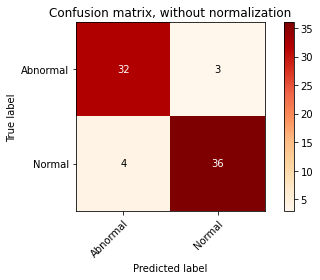

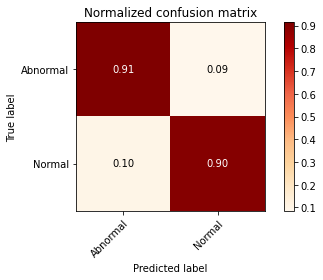

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft fine bi adam
--> 0.933

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_fine_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=2)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 300/300 [00:02<00:00, 120.69it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=2, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8031
Epoch 1: val_accuracy improved from -inf to 0.76000, saving model to model32_soft_fine_bi_adam.h5
7/7 [==============================] - 20s 1s/step - loss: 0.4790 - accuracy: 0.8031 - val_loss: 0.5201 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.2304 - accuracy: 0.9119
Epoch 2: val_accuracy did not improve from 0.76000
7/7 [==============================] - 3s 424ms/step - loss: 0.2304 - accuracy: 0.9119 - val_loss: 0.5728 - val_accuracy: 0.6800 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9845
Epoch 3: val_accuracy did not improve from 0.76000
7/7 [==============================] - 3s 473ms/step - loss: 0.1122 - accuracy: 0.9845 - val_loss: 0.6955 - val_accuracy: 0.6133 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.1059 - accuracy:

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

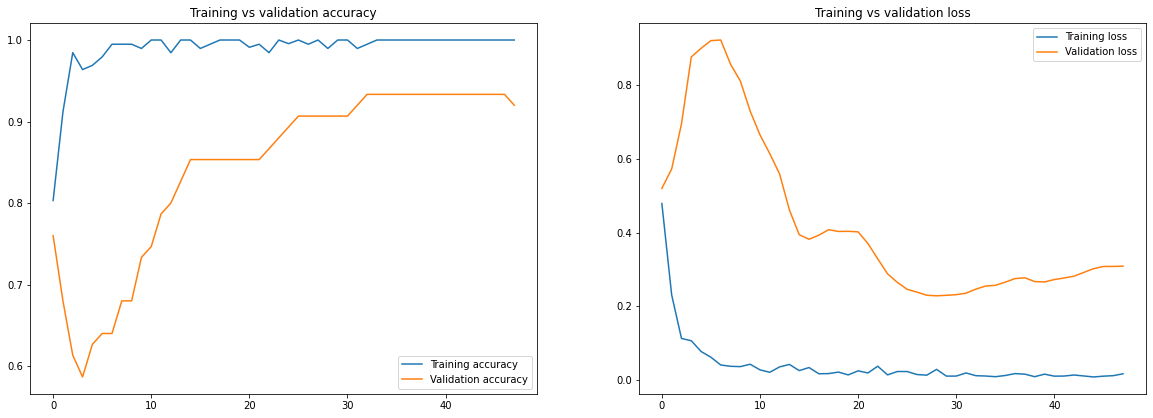

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[34  1]
 [ 5 35]]
Normalized confusion matrix
[[0.97 0.03]
 [0.12 0.88]]


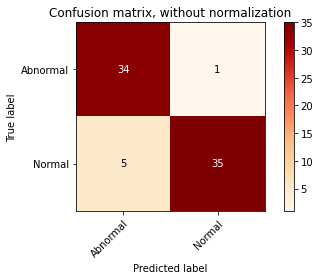

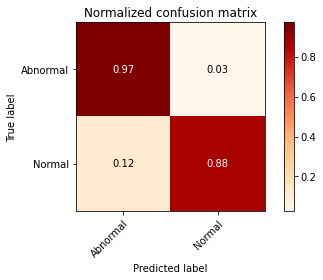

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
model = load_model(filepath)

In [ ]:
pred_model = model.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),   pred_model.argmax(axis=1), target_names=le_Dense.classes_))

              precision    recall  f1-score   support

    Abnormal       0.89      0.97      0.93        35
      Normal       0.97      0.90      0.94        40

    accuracy                           0.93        75
   macro avg       0.93      0.94      0.93        75
weighted avg       0.94      0.93      0.93        75



Confusion matrix, without normalization
[[34  1]
 [ 4 36]]
Normalized confusion matrix
[[0.97 0.03]
 [0.1  0.9 ]]


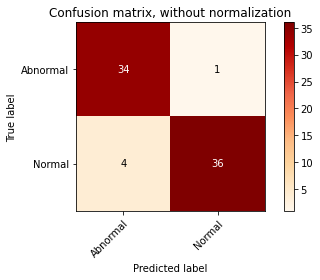

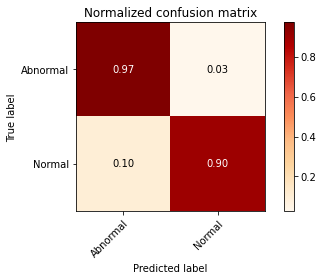

In [ ]:
y_pred = pred_model.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()